# CAPSIF Prediction on a single protein! #

### Input your file as __`my_file`__ below ###
### Or if using a PDB from the RCSB, change __`rcsb`__ to your 4 letter code of interest ###

## Change the necessary file then RUN ALL to get your results!!! ##

In [1]:
#Directory we will be storing information into!

my_file= "./sample_dir/4EXK_1_AF.pdb" #change to your file of interest!

rcsb = None # change to your favorite 4 letter code, try "3W26"

#Note that we assume RCSB is none and will only run the my_file until RCSB has a 4letter code input - MUST BE A STRING
#e.g. in easy format: if RCSB == None -> run my_file, else run RCSB


### Import Libraries ###

In [15]:
%matplotlib inline

import sys
import os

os.chdir(native_path)
os.chdir("./capsif_v/")
#CAPSIF:V requirements
sys.path.append("./capsif_v/")
from capsif_v.utils import xyz_to_rotate_to_voxelize_to_translate
from capsif_v.prediction_utils import load_model as load_voxel_model, command_run
from data_preparation.pdb_2_interaction_file_converter import pdb_to_interaction_file as capsif_v_pdb_preprocess
os.chdir('../')
sys.path.append('../')

os.chdir("./capsif_g/")
sys.path.append("./capsif_g/")
from capsif_g.dataset import load_predictor_model as load_graph_model
from notebook_library import download_pdb, predict_for_voxel as predict_voxel, visualize, preprocess_graph, predict_for_graph as predict_graph, output_structure_bfactor_biopython_BOTH as output_structure_bfactor
os.chdir("../")
sys.path.append("../")

#General requirements
import numpy as np
import py3Dmol
import math
import time
import torch

import matplotlib.pyplot as plt

pdb_colors = ['lime','gray','purple'] #colors for py3Dmol
voxel_colors = ['k','lightgray','lime'] #colors for voxel images

#If using a PDB structure from the RCSB

#Get the protein from the RCSB
#Download the pdb
if rcsb != None:
    pdb_file = download_pdb(rcsb,data_dir='./sample_dir/',assembly=0)
else:
    pdb_file = my_file;
pdb_file = os.path.abspath(pdb_file)

### Read in PDB file ###

In [16]:
# Initialize pdb into npz file for reading

#this is for the CAPSIF:V Model -> If you get zero predictions, feel free to alter some of the input flags :)
pdb_npz_file_reader = xyz_to_rotate_to_voxelize_to_translate()
pdb_npz_file_reader.max_rotation_plus_minus = 0
pdb_npz_file_reader.max_pixel_translate_per_axis = 0
pdb_npz_file_reader.use_res_index = 1
pdb_npz_file_reader.layers_use = 29
pdb_npz_file_reader.layer_29_type = 2
pdb_npz_file_reader.cube_start_points = 1
pdb_npz_file_reader.crop_extra_edge = 0
pdb_npz_file_reader.cube_start_points = 1

start_time = time.time()
f = capsif_v_pdb_preprocess( pdb_file, 'sample_dir/',
                                    0, verbose=0,
                                    use_glycan=1)
f.carb_aa_distance_calc_and_save = 1
f.save_data =0
s,x = f.run_me()

#get the carbohydrate residues of the protein for visualization
carbs = f.carb_pdb;
carb_res = []
for ii in carbs:
    split=ii.split(' ')
    carb_res.append(split[0] + "." + split[1])
    
if len(x) <= 1:
    if len(x) == 0:
        print("Can not read pdb file! Not a protein data.")
        
    if x[0] == -1:
        print("PyRosetta could not read glycan!")
        print("Check PDB file (ring glycan, clashes etc.)!")
        print("or use restart the code and run 'load_glycan_off' flag. Dice will be 0")
        
        
proteins,masks = pdb_npz_file_reader.apply(x,s)
        
pdb_time = time.time()
print("PyRosetta + PDB load time: ","%5.1f " % (pdb_time -start_time), "seconds.\n")

PyRosetta-4 2021 [Rosetta PyRosetta4.Release.python38.mac 2021.36+release.57ac713a6e1d8ce6f60269b3988b1adac1d96fc6 2021-09-10T13:50:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta + PDB load time:    1.9  seconds.



### Visualize PDB ###

Input PDB


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

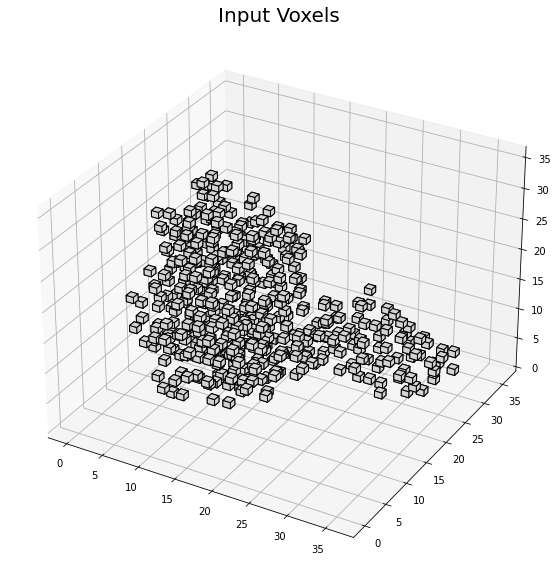

In [17]:
print("Input PDB")

visualize(pdb_file,carb_res,colors=pdb_colors)

print("\n\n")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.voxels(proteins[0],facecolor=voxel_colors[1],edgecolor=voxel_colors[0])
plt.title("Input Voxels",fontsize=20)
plt.show()

### Load Models and Run Prediction ###

In [18]:
#Load the Model
os.chdir('capsif_v')
start_time = time.time()
model = load_voxel_model(2,2)
model_time = time.time()
print("Model load time: ","%5.1f " % (model_time -start_time), "seconds.\n")

#Run prediction
start_time = time.time()

d,voxel_res,py_com,pred_vox=predict_voxel(torch.from_numpy(proteins), torch.from_numpy(masks), model,  2 ,save_npz=0)

pred_time = time.time()
print("Voxel Total prediction time: ","%5.1f " % (pred_time -start_time), "seconds.")
os.chdir(native_path)

Using /Users/scanner1/Downloads/capsif_repo/CAPSIF/capsif_v/models_DL/my_checkpoint_best_36_2A_CACB_vector_coord_I_clean_data.pth.tar
=> Loading checkpoint
Model load time:    0.9  seconds.

Voxel Total prediction time:    1.0  seconds.


In [19]:
graph_model_dir = "./capsif_g/models_DL/cb_model.pth.tar"
start_time = time.time()
graph_model = load_graph_model(graph_model_dir)
model_time = time.time()
print("Graph Model load time: ","%5.3f " % (model_time -start_time), "seconds.\n")

print("Graph Prediction")
os.chdir('capsif_g')
start_time = time.time()
graph_dice, graph_results, graph_res = predict_graph(pdb_file,model=graph_model)
model_time = time.time()
os.chdir('..')
print("Graph total prediction time: ","%5.1f " % (model_time -start_time), "seconds.")

Graph Model load time:  0.037  seconds.

Graph Prediction
PyRosetta-4 2021 [Rosetta PyRosetta4.Release.python38.mac 2021.36+release.57ac713a6e1d8ce6f60269b3988b1adac1d96fc6 2021-09-10T13:50:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
Graph total prediction time:    3.1  seconds.


In [20]:
#print("CAPSIF:V Pymol Paper Visualization:")
#print(py_com)

### Visualize Output ###

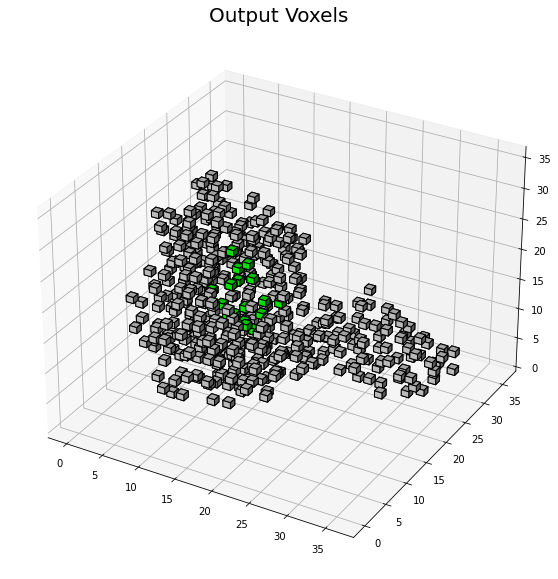



CAPSIF:V Predicted Residues


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
#display the pdb and predictions!
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.voxels(proteins[0],facecolors=voxel_colors[1],edgecolor=voxel_colors[0])
ax.voxels(pred_vox[0,0,...],facecolors=voxel_colors[2],edgecolor=voxel_colors[0])
plt.title("Output Voxels",fontsize=20)
plt.show()

print("\n")

print("CAPSIF:V Predicted Residues")
visualize(pdb_file,carb_res,voxel_res,colors=pdb_colors)

In [22]:
#display the pdb and predictions!
print("CAPSIF:G Predicted Residues")
visualize(pdb_file,carb_res,graph_res,colors=pdb_colors)

CAPSIF:G Predicted Residues


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
#output the file prediction to a pdb
output_structure_bfactor(in_file=pdb_file,res_v=voxel_res,res_g=graph_res,out_file= pdb_file[:pdb_file.index('.')] + "_predictions.pdb")